# DQN from scratch

[Source](https://github.com/Curt-Park/rainbow-is-all-you-need/blob/master/01.dqn.ipynb). There are three key algorithmic features which contribute to the stability of DQN:  
1. Replay Buffer
2. Fixed Target Network
3. Gradient Clipping

## Imports & Constants

In [9]:
import time
import highway_env
import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from abc import abstractmethod, ABC
from typing import Dict, List, Tuple
from IPython.display import clear_output

## Replay Buffer

In this simple implementation of a Replay Buffer, samples are drawn uniformly with no priority.

In [2]:
class ReplayBuffer:
    """
    Class representing a simple replay buffer that accepts stacked images.
    """
    
    def __init__(self, obs_shape: Tuple, size: int, batch_size: int = 32):
        self.obs_buf = np.zeros([size, *obs_shape], dtype=np.float32)
        self.next_obs_buf = np.zeros([size, *obs_shape], dtype=np.float32)

        self.acts_buf = np.zeros([size], dtype=np.float32)
        self.rews_buf = np.zeros([size], dtype=np.float32)
        self.done_buf = np.zeros(size, dtype=np.float32)

        self.max_size = size
        self.batch_size = batch_size

        self.ptr = 0
        self.size = 0

    def store(self, obs: np.ndarray, act: np.ndarray, rew: np.ndarray, next_obs: np.ndarray, done: bool):
        self.obs_buf[self.ptr] = obs
        self.next_obs_buf[self.ptr] = next_obs
        self.acts_buf[self.ptr] = act
        self.rews_buf[self.ptr] = rew
        self.done_buf[self.ptr] = done

        self.ptr = (self.ptr + 1) % self.max_size
        self.size = min(self.size + 1, self.max_size)

    def sample_batch(self) -> Dict[str, np.ndarray]:
        # Draw `batch_size` no. samples (without replacement) as indexes.
        idxs = np.random.choice(self.size, size=self.batch_size, replace=False)

        return dict(
            obs=self.obs_buf[idxs],
            next_obs=self.next_obs_buf[idxs],
            acts=self.acts_buf[idxs],
            rews=self.rews_buf[idxs],
            done=self.done_buf[idxs],
        )
    
    def __len__(self) -> int:
        return self.size

## Network

Contains three fully connected layers and two activation (non-linearity) functions.

In [3]:
class Network(nn.Module):

    def __init__(self, in_dim: int, out_dim: int):
        """
        Instantiates a three-layer feed-forward neural network.
        """
        super().__init__()

        self.layers = nn.Sequential(
            nn.Linear(in_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, out_dim)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Performs a forward pass of the neural network.
        """
        return self.layers(x)

## DQN Agent

In [4]:
class BaseDQNAgent(ABC):
    """
    Base class for DQN agents.
    """

    def __init__(
        self,        
        env: gym.Env,
        memory_size: int,
        batch_size: int,
        target_update: int,
        epsilon_decay: float,
        seed: int,
        max_epsilon: float = 1.0,
        min_epsilon: float = 0.1,
        gamma: float = 0.99,
    ):
        self.obs_shape = env.observation_space.shape
        self.action_dim = env.action_space.n

        self.env = env
        self.batch_size = batch_size
        self.epsilon = max_epsilon
        self.epsilon_decay = epsilon_decay
        self.seed = seed
        self.max_epsilon = max_epsilon
        self.min_epsilon = min_epsilon
        self.target_update = target_update
        self.gamma = gamma
        self.memory_size = memory_size

        self.device = torch.device(
            "cuda" if torch.cuda.is_available() else "cpu"
        )
        print(self.device)

        # DQN Networks (to be instantiated)
        self.dqn = None
        self.dqn_target = None

        # Experience Replay Buffer.
        self.memory = ReplayBuffer(self.obs_shape, memory_size, batch_size)
        # Next transition to store in memory.
        self.transition = list()

        # Mode: train/test.
        self.is_test = False

        self._init_seed(seed)

    def set_mode(self, is_test: bool):
        self.is_test = is_test

    def predict(self, state: np.ndarray, determinstic: bool = True) -> np.ndarray:
        """
        Selects an action from the input state using a (potentially) epsilon-greedy policy.
        """
        return self.select_action(state, determinstic)
    
    @abstractmethod
    def select_action(self, state: np.ndarray, determinstic: bool = False) -> np.ndarray:
        """
        Selects an action from the input state using an epsilon-greedy policy.
        """
        raise NotImplementedError()
    
    def step(self, action: np.ndarray) -> Tuple[np.ndarray, np.float64, bool]:
        """
        Takes an action and returns the response of the env.
        """
        next_state, reward, terminated, truncated, _ = self.env.step(action)
        done = terminated or truncated

        if not self.is_test:
            self.transition += [reward, next_state, done]
            self.memory.store(*self.transition)

        return next_state, reward, done
    
    def update_model(self) -> torch.Tensor:
        """
        Updates the model by gradient descent.
        """
        samples = self.memory.sample_batch()

        loss = self._compute_dqn_loss(samples)
        
        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()

        return loss.item()
    
    def train(self, num_frames: int, plotting_interval: int = 200):
        """
        Trains the agent.
        """
        self.is_test = False
        state, _ = self.env.reset()

        update_count = 0
        epsilons = []
        losses = []
        scores = []
        score = 0

        for frame_idx in range(num_frames):
            action = self.select_action(state)
            next_state, reward, done = self.step(action)

            state = next_state
            score += reward

            if done:
                # The episode has ended.
                state, _ = self.env.reset()
                
                scores.append(score)
                score = 0

            if len(self.memory) >= self.batch_size:
                # Training is ready once the replay buffer contains enough transition samples.
                loss = self.update_model()
                losses.append(loss)
                update_count += 1

                # Linearly decrease epsilon
                self.epsilon = max(
                    self.min_epsilon,
                    self.epsilon - (
                        self.max_epsilon - self.min_epsilon
                    ) * self.epsilon_decay
                )
                epsilons.append(self.epsilon)

                # If a hard update of the target network is needed.
                if update_count % self.target_update == 0:
                    self._target_hard_update()

            if (frame_idx + 1) % plotting_interval == 0:
                self._plot(frame_idx + 1, scores, losses, epsilons)

        self.env.close()

    @abstractmethod
    def _compute_dqn_loss(self, samples: Dict[str, np.ndarray]) -> torch.Tensor:
        """
        Computes and returns the DQN loss.
        """
        raise NotImplementedError()

    def _target_hard_update(self):
        """
        Performs a hard update of the target network: target <- behavioural.
        """
        self.dqn_target.load_state_dict(self.dqn.state_dict())

    def _plot(
        self, 
        frame_idx: int, 
        scores: List[float], 
        losses: List[float], 
        epsilons: List[float],
    ):
        """Plots the training progress."""
        clear_output(True)
        plt.figure(figsize=(20, 5))
        plt.subplot(131)
        plt.title('frame %s. score: %s' % (frame_idx, np.mean(scores[-25:])))
        # Plot the rolling mean score of the last 25 episodes.
        plt.plot(self._calculate_rolling_mean(scores, 25))
        plt.subplot(132)
        plt.title('loss')
        plt.plot(losses[20:])
        plt.subplot(133)
        plt.title('epsilons')
        plt.plot(epsilons)
        plt.show()

    def _calculate_rolling_mean(self, data: List, window_size: int) -> np.ndarray:
        window = np.ones(window_size) / window_size
        return np.convolve(data, window, mode='valid')

    def _init_seed(self, seed: int):
        torch.manual_seed(seed)

        if torch.backends.cudnn.enabled:
            torch.cuda.manual_seed(seed)
            torch.backends.cudnn.benchmark = False
            torch.backends.cudnn.deterministic = True

        np.random.seed(seed)


class MlpDQNAgent(BaseDQNAgent):
    """
    Class representing a DQN agent.
    """

    def __init__(
        self,
        env: gym.Env,
        memory_size: int,
        batch_size: int,
        target_update: int,
        epsilon_decay: float,
        seed: int,
        max_epsilon: float = 1.0,
        min_epsilon: float = 0.1,
        gamma: float = 0.99,
    ):
        super().__init__(
            env, 
            memory_size, 
            batch_size, 
            target_update, 
            epsilon_decay, 
            seed, 
            max_epsilon, 
            min_epsilon, 
            gamma
        )
        # Networks: DQN behaviour network, DQN target network
        obs_dim = np.prod(self.obs_shape)
        self.dqn = Network(obs_dim, self.action_dim).to(self.device)
        self.dqn_target = Network(obs_dim, self.action_dim).to(self.device)
        self.dqn_target.load_state_dict(self.dqn.state_dict())
        self.dqn_target.eval()

        # Optimiser
        self.optimiser = optim.Adam(self.dqn.parameters())

    def select_action(self, state: np.ndarray, determinstic: bool = False) -> np.ndarray:
        """
        Selects an action from the input state using an epsilon-greedy policy.
        """
        if not determinstic and np.random.random() < self.epsilon:
            selected_action = self.env.action_space.sample()
        else:
            flattened_state = state.flatten()
            selected_action = self.dqn(
                torch.FloatTensor(flattened_state).to(self.device)
            ).argmax()
            selected_action = selected_action.detach().cpu().numpy()

        if not self.is_test:
            self.transition = [state, selected_action]

        return selected_action

    def _compute_dqn_loss(self, samples: Dict[str, np.ndarray]) -> torch.Tensor:
        """
        Computes and returns the DQN loss.
        """
        device = self.device

        # Shape = (batch_size, obs dim 1, obs dim 2, ...)
        # This flattens the observation dimensions of `state` and `next_state`.
        state = torch.FloatTensor(samples["obs"].reshape(self.batch_size, -1)).to(device)
        next_state = torch.FloatTensor(samples["next_obs"].reshape(self.batch_size, -1)).to(device)

        # Reshapes each 1-dimesional array into a 2-dimensional array with one column.
        action = torch.LongTensor(samples["acts"].reshape(-1, 1)).to(device)
        reward = torch.FloatTensor(samples["rews"].reshape(-1, 1)).to(device)
        done = torch.FloatTensor(samples["done"].reshape(-1, 1)).to(device)

        # G_t = r + gamma * v(s_{t+1}) if state != terminal
        #     = r                      otherwise
        curr_q_value = self.dqn(state).gather(1, action)
        next_q_value = self.dqn_target(next_state).max(dim=1, keepdim=True)[0].detach()
        mask = 1 - done
        target = (reward + self.gamma * next_q_value * mask).to(device)

        # Calculate DQN loss
        loss = F.smooth_l1_loss(curr_q_value, target)

        return loss

# Train an agent

In [18]:
config = {
    'duration': 100,
    'lanes_count': 3,
}

In [19]:
env = gym.make("highway-fast-v0", render_mode="rgb_array")
env.unwrapped.configure(config)
obs, info = env.reset()

In [20]:
seed = 777
num_frames = 100_000
memory_size = 4_000
gamma = 0.8
batch_size = 64
target_update = 50
epsilon_decay = 1 / (num_frames // 10)

agent = MlpDQNAgent(
    env,
    memory_size,
    batch_size,
    target_update,
    epsilon_decay,
    seed,
    gamma = gamma
)

cuda


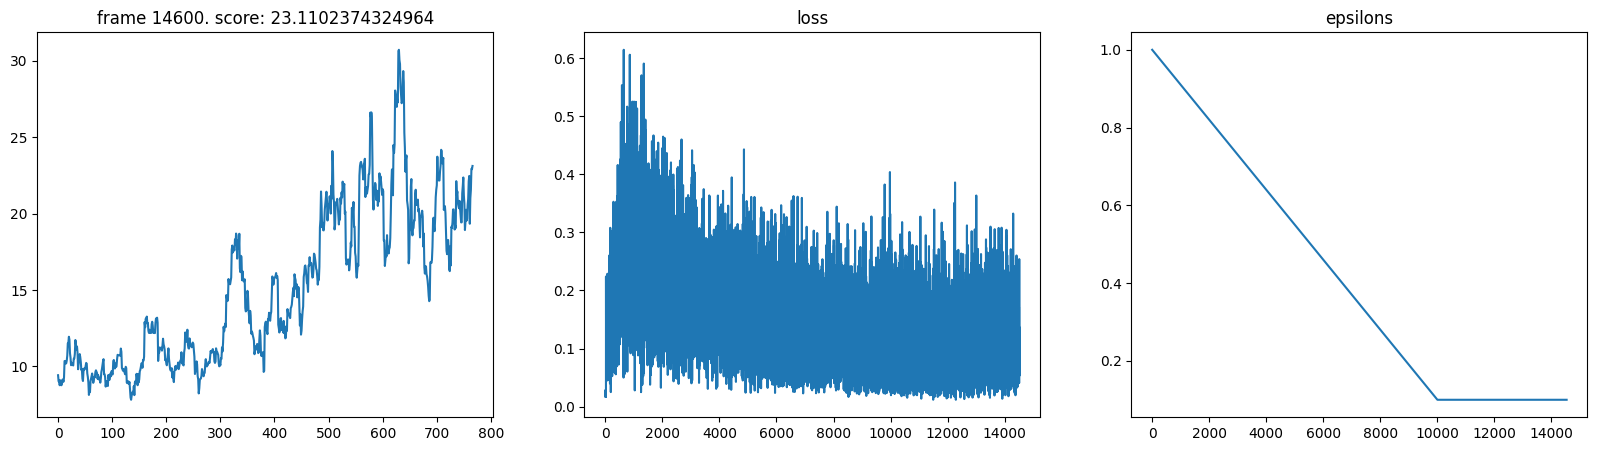

In [21]:
agent.train(num_frames)

# Test the agent

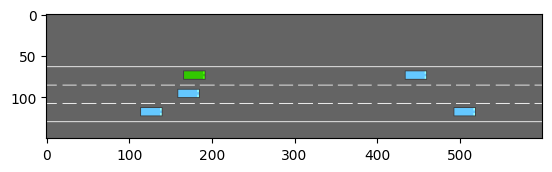

In [13]:
agent.set_mode(is_test=True)

episode_lengths = []
undiscounted_rewards = []

for episode in range(100):
    done = truncated = False
    obs, info = env.reset()

    episode_reward = 0
    episode_length = 0

    while not (done or truncated):
        action = agent.predict(obs, True)
        obs, reward, done, truncated, info = env.step(action)

        episode_reward += reward
        episode_length += 1

        clear_output(True)
        plt.imshow(env.render())
        plt.show()
        # time.sleep(0.2)

    undiscounted_rewards.append(episode_reward)
    episode_lengths.append(episode_length)